# Pràctica 3.5: Entrenar una XNN i controlar el robot amb ella 

## Introducció

Com a enfocament alternatiu veurem com generar dades d'entrenament amb imatges apropiades per a la nostra XNN. A continuació entrenarem la XNN amb aquestes dades i finalment controlarem el robot amb la XNN entrenada.

In [37]:
!pip install aitk numpy opencv-python-headless matplotlib requests keras tensorflow

## Preparem l'entorn

In [38]:
import pathlib
import time
import random


import aitk.robots as bots
import numpy as np
import matplotlib.pyplot as plt
import cv2
import requests
import keras
print(keras.__version__)

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.layers import Rescaling

3.3.3


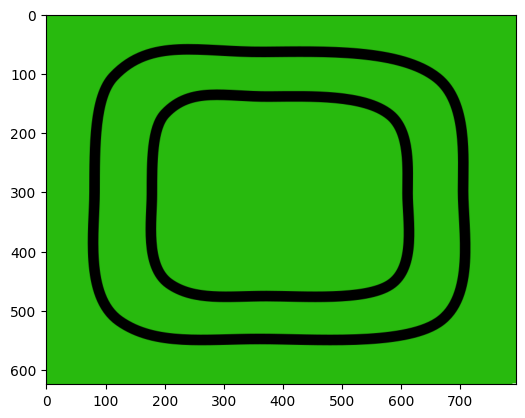

In [ ]:
nom_imatge = "pista_6.png"

url = "https://lawer.github.io/mia/apunts/2.-segon_trimestre/9.-Rob%C3%B3tica/" + nom_imatge

response = requests.get(url)

# Guardem la imatge

with open(nom_imatge, "wb") as f:
    f.write(response.content)

# Carreguem la imatge en una variable

img = cv2.imread(nom_imatge)

# Mostrem la imatge
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [40]:
def generate_data(robot, world, trials):
    global data
    data = []
    for i in range(trials):
        world.reset()

world = bots.World(220, 180, boundary_wall_color="yellow", ground_image_filename=nom_imatge)

amplada_camera = 120
alcada_camera = 50
robot = bots.Scribbler(x=36, y=80, a=90)
robot.add_device(bots.GroundCamera(width=amplada_camera, height=alcada_camera))

world.add_robot(robot)

robot['ground-camera'].watch()
world.watch()

Random seed set to: 4644633


HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00x\x00\x00\x002\x08\x06\x00\x00\x00\x97\xa7\x1f\xd…

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x0…

## Generant valors de moviment i rotació

En la pràctica anterior, vau controlar directament el robot cridant `robot.move(translate, rotate)`. Ara volem moure el robot i guardar els moviments en un fitxer. Per fer-ho, crearem una funció anomenada `determine_move`  que prengui els valors actuals dels sensors i retorne una tupla amb una ruta a la imatge captada (que haurem guardat en disc), la velocitat i rotació actuals i un boolea que indica que si s'ha d'acabar el programa. 

Aquesta funció es cridarà en cada iteració del bucle principal.

In [41]:
# directori actual
directori = pathlib.Path().resolve()

def determine_move(robot):
    """
    Determina el moviment del robot en funció de les seves lectures de sensors.
    Retorna una tupla amb la velocitat de translació, la velocitat de rotació i un booleà que indica si s'ha de parar.

    El robot ha de mantenir-se dins de la pista fins tornar a l'inici.
    """
    cam = robot['ground-camera']

    # capturem una imatge de la càmera. Convertim a RGB per llevar el canal alpha (transparència) que no necessitem
    image = cam.get_image().convert('RGB')

    # ...
    
                
    return moviment, False


#### Testejant la funció `determine_move`

Hem de provar la funció `determine_move` i verificar que encara controla adequadament el robot per seguir la paret. Per fer-ho, cridarem la funció `determine_move` en un bucle i cridarem `robot.move` amb els valors de moviment retornats per la funció `determine_move`. Això hauria de fer que el robot vaja pel circuit sense cap problema.

In [42]:
def controlador_cam(robot):    
    velocitat, rotacio, ruta_imatge, parar = determine_move(robot)

    robot.move(velocitat, rotacio)

    if parar:
        print("STOP")
        return True


In [43]:
world.reset()
world.seconds(30, [controlador_cam], real_time=False)

Using random seed: 4644633


  0%|          | 0/300 [00:00<?, ?it/s]

(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829376.5451875.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829376.5458202.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829376.5464418.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829376.5469284.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829376.5474446.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829376.5479639.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829376.5485637.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829376.5491104.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829376.5496862.png
(

### Generant dades d'entrenament 

Ara tenim totes les peces en el lloc per generar les dades d'entrenament.

Volem generar un conjunt de dades d'entrenament per a la nostra xarxa neuronal i el simulador en temps real serà massa lent. Per tant, utilitzarem la versió no en temps real del simulador. Per aixó utilitzarem `realtime = False` quan cridem a `world.seconds`.

Un problema que potencialment hem d'abordar és que el nostre programa de recòrrer el circuit pot quedar-se aturat en certes situacions o anar enrere. Hem de construir la nostra funció de generació de dades amb això en ment. Per exemple, si el robot es queda aturat, no volem que les dades d'entrenament reflecteixin aquesta situació.
preprocessing
Crearem la funció `generate_data` que generi una llista de dades d'entrenament. Aquesta funció hauria de generar un nombre fix de dades d'entrenament. Per cada iteració d'entrenament, la funció hauria de reiniciar el mon i executar una simulació.

In [44]:
def generate_data(robot, world, trials):
    """Aquí haurà de generar les dades per entrenar la xarxa neuronal."""
        

In [45]:
generate_data(robot, world, 20)

Using random seed: 4644633


  0%|          | 0/300 [00:00<?, ?it/s]

(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829376.869067.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829376.872804.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829376.873815.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829376.8743246.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829376.8748705.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829376.8754234.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829376.8759964.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829376.876682.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829376.8772576.png
(50, 

  0%|          | 0/300 [00:00<?, ?it/s]

(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829377.1544483.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829377.1553845.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829377.155997.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829377.1566596.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829377.1572976.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829377.157903.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829377.1585014.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829377.1591825.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829377.159894.png
(50,

  0%|          | 0/300 [00:00<?, ?it/s]

(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829377.4499056.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829377.450591.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829377.4513435.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829377.4518902.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829377.4524288.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829377.4529634.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829377.4535358.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829377.4540749.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829377.4546177.png
(5

  0%|          | 0/300 [00:00<?, ?it/s]

(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829377.7506475.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829377.751582.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829377.7523963.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829377.753221.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829377.754135.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829377.754905.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829377.7556577.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829377.7565095.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829377.7572784.png
(50, 

  0%|          | 0/300 [00:00<?, ?it/s]

(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.0696547.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.0704439.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.0710707.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.0716152.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.0721357.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.0726526.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.0731654.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.0737069.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.0742855.png
(

  0%|          | 0/300 [00:00<?, ?it/s]

(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.3621304.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.3628252.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.3633995.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.3639185.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.3644352.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.3649423.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.3654673.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.3659766.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.3665044.png
(

  0%|          | 0/300 [00:00<?, ?it/s]

(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.6444519.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.6450977.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.6456487.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.646184.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.6467092.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.6472297.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.6477523.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.6482716.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.6488147.png
(5

  0%|          | 0/300 [00:00<?, ?it/s]

(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.930175.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.9310045.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.931653.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.9322767.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.9328737.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.9335055.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.93412.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.93474.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829378.935352.png
(50, 120

  0%|          | 0/300 [00:00<?, ?it/s]

(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829379.1895344.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829379.1928103.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829379.1935153.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829379.194142.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829379.1946821.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829379.1952178.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829379.1957715.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829379.19632.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829379.19689.png
(50, 1

  0%|          | 0/300 [00:00<?, ?it/s]

(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829379.4748785.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829379.475567.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829379.4761045.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829379.4766262.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829379.4771423.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829379.4776714.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829379.4785204.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829379.4790242.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829379.479546.png
(50

  0%|          | 0/300 [00:00<?, ?it/s]

(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829379.7390826.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829379.7397435.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829379.7403378.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829379.7409194.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829379.7414908.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829379.742067.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829379.7426767.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829379.7432613.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829379.7438462.png
(5

  0%|          | 0/300 [00:00<?, ?it/s]

(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.0397105.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.0403636.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.0409029.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.04143.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.0419781.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.0425293.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.0430508.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.043965.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.0444038.png
(50,

  0%|          | 0/300 [00:00<?, ?it/s]

(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.3125482.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.3183312.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.31992.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.3216453.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.3230422.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.3243783.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.3258073.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.3273907.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.3287504.png
(50

  0%|          | 0/300 [00:00<?, ?it/s]

(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.666857.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.667495.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.6680403.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.6685767.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.6691434.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.669761.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.6703348.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.6708817.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.6714323.png
(50,

  0%|          | 0/300 [00:00<?, ?it/s]

(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.9920409.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.9927406.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.9933202.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.9938889.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.994429.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.9949834.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.9955637.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.9960918.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829380.996613.png
(50

  0%|          | 0/300 [00:00<?, ?it/s]

(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829381.2511532.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829381.2519379.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829381.2524903.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829381.2530406.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829381.2535956.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829381.2541544.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829381.2546864.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829381.2552338.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829381.255773.png
(5

  0%|          | 0/300 [00:00<?, ?it/s]

(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829381.6181083.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829381.6187763.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829381.619309.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829381.6198268.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829381.6233494.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829381.623947.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829381.624486.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829381.62505.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829381.6256914.png
(50, 1

  0%|          | 0/300 [00:00<?, ?it/s]

(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829381.9088442.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829381.9095032.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829381.910083.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829381.9106135.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829381.9111407.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829381.9116604.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829381.912177.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829381.9126978.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829381.9132552.png
(50

  0%|          | 0/300 [00:00<?, ?it/s]

(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829382.2007232.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829382.2015285.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829382.2023847.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829382.2029626.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829382.2035263.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829382.204102.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829382.204714.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829382.2053235.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829382.205971.png
(50,

  0%|          | 0/300 [00:00<?, ?it/s]

(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829382.5192974.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829382.5200448.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829382.52064.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829382.521199.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829382.5217447.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829382.5222778.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829382.5228066.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829382.523333.png
(50, 120, 3)
/home/carles/Documentos/notebooks/robotica/ds_controlar_robot/recte/imatge_1715829382.526904.png
(50, 1

Finalitzem aquesta secció guardant les dades d'entrenament en un fitxer.

In [ ]:
processed_lines = []

for line in data:
    # ...

with open("training_data.txt", "w") as f:
    f.writelines(processed_lines)


Finalitzem aquesta secció guardant les dades d'entrenament en un fitxer.

## Creació del dataset

Per començar, carregarem les dades d'entrenament que hem generat. Aquestes dades són les imatges capturades i els moviments que s'han fet.

In [46]:
def carrega_dades_entrenament(nom_fitxer):
    """Retorna les dades d'entrenament"""

    #...

    return patrons

Found 6300 files belonging to 3 classes.
Using 5040 files for training.
Found 6300 files belonging to 3 classes.
Using 1260 files for validation.


In [ ]:
patrons = carrega_dades_entrenament("training_data.txt")
len(patrons)

In [ ]:
# Vejam quants paràmetres tenen els patrons
print(len(patrons[0]))

Mostrem una imatge del dataset per comprovar que s'han carregat correctament.

In [ ]:
# Observem un exemple

patro = patrons[0]
imatge = patro[0]

plt.imshow(cv2.cvtColor(imatge, cv2.COLOR_BGR2RGB))
plt.title(f"Velocitat: {patro[1]}, Rotació: {patro[2]}")
plt.axis("off")

plt.show()

Finalment, separarem les dades en dades d'entrenament i dades de prova i separarem les imatges i els moviments esperats.

In [ ]:
patrons_entrenament = patrons[:int(len(patrons) * 0.8)]
patrons_validacio = patrons[int(len(patrons) * 0.8):]

def separa_dades(dades):
    #...
     
x_train, y_train = separa_dades(patrons_entrenament)
x_test, y_test = separa_dades(patrons_validacio)

print(len(x_train), len(y_train))
x_train[0].shape

## Entrenament de la XNN

Crearem una xarxa neuronal que sigui capaç de predir el moviment següent del robot. La xarxa neuronal hauria de tenir una capa d'entrada tan gran com el tamany de les imatges (120x50x3 = 18000), una capa de reescalament, al menys una capa de convolució, una d'aplanament i una capa de sortida amb 3 neurones (una per a cada moviment).

In [48]:
net = keras.Sequential([
    # ...
])

net.compile(
    # ...
)

/home/carles/Documentos/mia/.venv/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [49]:
net.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10)

Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8353 - loss: 0.5036 - val_accuracy: 0.9960 - val_loss: 0.0194
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9950 - loss: 0.0263 - val_accuracy: 1.0000 - val_loss: 0.0089
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9933 - loss: 0.0257 - val_accuracy: 1.0000 - val_loss: 0.0050
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9998 - loss: 0.0050 - val_accuracy: 1.0000 - val_loss: 0.0047
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9989 - loss: 0.0052 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9999 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 8/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.

### Testejant la XNN

Per comprovar que la XNN funciona correctament, utilitzarem la funció `predict` per predir el moviment següent del robot. A continuació, cridarem `robot.move` amb els valors corresponents.

In [ ]:
# Observem un exemple
patro = patrons[0]
imatge = patro[0]

plt.imshow(cv2.cvtColor(imatge, cv2.COLOR_BGR2RGB))
predit = net.predict(np.array([imatge]))

plt.title(f"V: {patro[1]}, R: {patro[2]} VP: {round(predit[0][0], 2)}, RP: {round(predit[0][1], 2)}")
plt.axis("off")

plt.show()

### Controlant el robot amb la XNN

Finalment, controlarem el robot amb la XNN entrenada. En cada iteració, cridarem la funció `predict` per predir el moviment següent del robot i cridarem `robot.move` amb els valors corresponents.

In [53]:
def controlador_cam(robot):
    cam = robot['ground-camera']
    image = cam.get_image().convert('RGB')

    # ...

world.reset()
world.seconds(30, [controlador_cam], real_time=False)
        

Using random seed: 4644633


  0%|          | 0/300 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[[6.7574588e-14 2.0780282e-21 1.0000000e+00]]
recte
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[[6.8339980e-14 2.2127334e-21 1.0000000e+00]]
recte
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[6.9109953e-14 2.3712190e-21 1.0000000e+00]]
recte
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[[7.0827567e-14 2.7515856e-21 1.0000000e+00]]
recte
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[[7.2923411e-14 3.2606535e-21 1.0000000e+00]]
recte
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[[7.8063092e-14 4.3286378e-21 1.0000000e+00]]
recte
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[[9.2393114e-14 6.7438521e-21 1.0000000e+00]]
recte
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[[1.10341803e-13 1.00387326e-20 1.00000000e+00]]
recte
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[[1.6041353e-13 1.7140809e-20 1.0000000e+00]]
recte
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[[3.4370011e-13 5.3275278e-20 1.0000000e+00]]
recte
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[[1.2455742e-12 4.9302622e-19 1.0000000e+00]]
recte
1/1 ━━━━━━